# 1. Data preparation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
X, y = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, n_classes=3, n_clusters_per_class=1, random_state=42)

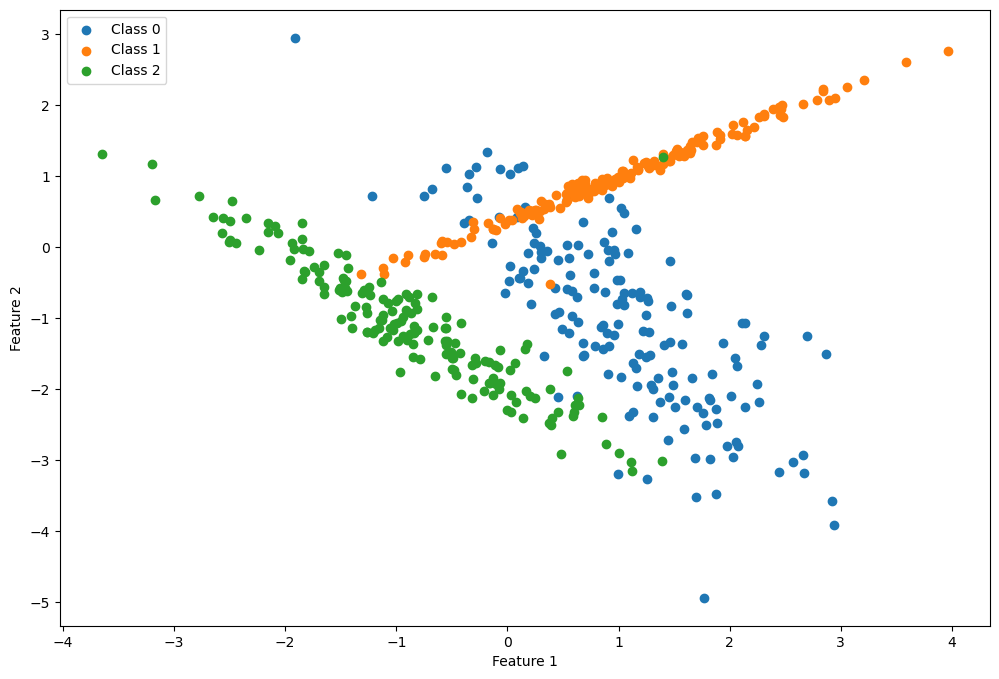

In [3]:
plt.figure(figsize=(12,8))
plt.scatter(X[y==0][:, 0], X[y==0][:, 1], label="Class 0")
plt.scatter(X[y==1][:, 0], X[y==1][:, 1], label="Class 1")
plt.scatter(X[y==2][:, 0], X[y==2][:, 1], label="Class 2")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

In [4]:
sc = StandardScaler()
X_std = sc.fit_transform(X)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.3, random_state=42)

# 2. PyTorch

## 2.1 nn.Sequential

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

In [11]:
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.long)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.long)

In [8]:
torch_model_seq = nn.Sequential(
    nn.Linear(2, 16),
    nn.ReLU(),
    nn.Linear(16, 3) #output logits, let the loss handle softmax part
)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(torch_model_seq.parameters(), lr=0.01)
losses_torch_seq = []

In [12]:
for epoch in range(100):
    optimizer.zero_grad()
    outputs = torch_model_seq(X_train_torch)
    loss = criterion(outputs, y_train_torch)
    loss.backward()
    optimizer.step()
    losses_torch_seq.append(loss.item())

## 2.2 nn.Module

In [13]:
class MyMLPModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 3)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model_torch_module = MyMLPModule()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_torch_module.parameters(), lr=0.01)
losses_torch_module = []

for epoch in range(100):
    optimizer.zero_grad()
    logits = model_torch_module(X_train_torch)
    loss = criterion(logits, y_train_torch)
    loss.backward()
    optimizer.step()
    losses_torch_module.append(loss.item())

## 2.3 Visualize the loss curve

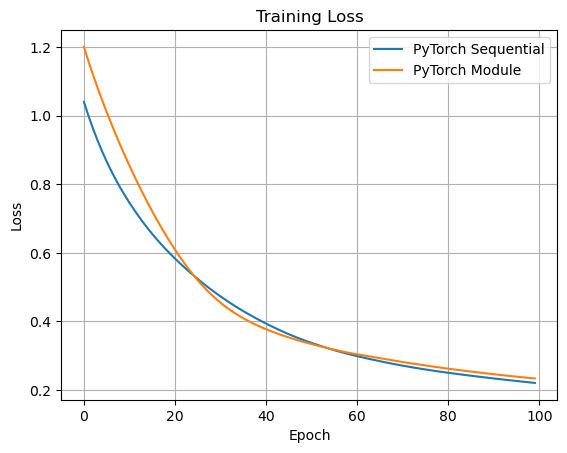

In [14]:
plt.plot(losses_torch_seq, label='PyTorch Sequential')
plt.plot(losses_torch_module, label='PyTorch Module')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

## 2.4 Decision boundary

In [17]:
def plot_decision_boundary(model, X, y, title, is_torch=True):
    x_min, x_max = X[:, 0].min()-1, X[:, 0].max()+1
    y_min, y_max = X[:, 1].min()-1, X[:, 1].max()+1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    if is_torch:
        with torch.no_grad():
            Z = model(torch.tensor(grid, dtype=torch.float32))
            Z = torch.argmax(Z, axis=1).reshape(xx.shape)
    else:
        Z = model(tf.convert_to_tensor(grid, dtype=tf.float32))
        Z = tf.argmax(Z, axis=1).numpy().reshape(xx.shape)

    plt.figure(figsize=(6,5))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.Spectral)
    plt.scatter(X[:,0], X[:,1], c=y, edgecolors='k', cmap=plt.cm.Spectral)
    plt.title(title)
    plt.grid(True)
    plt.show()

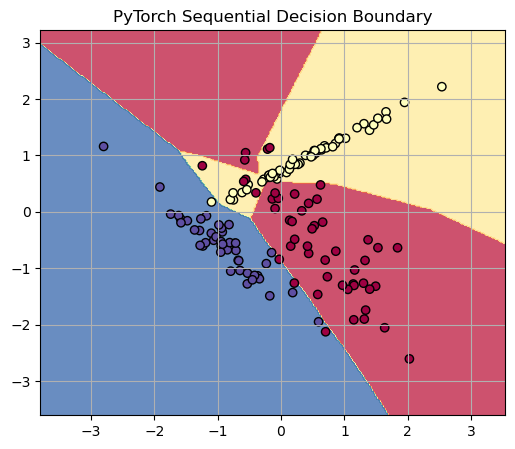

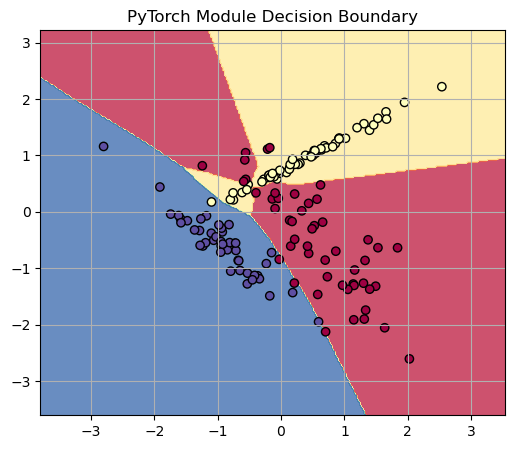

In [19]:
plot_decision_boundary(torch_model_seq, X_test, y_test, "PyTorch Sequential Decision Boundary", is_torch=True)
plot_decision_boundary(model_torch_module, X_test, y_test, "PyTorch Module Decision Boundary", is_torch=True)

# 3. Tensorflow

## 3.1 Sequential

In [22]:
import tensorflow as tf

X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_train, dtype=tf.int32)
X_test_tf = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tf = tf.convert_to_tensor(y_test, dtype=tf.int32)

In [23]:
tf_model_seq = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(3)
])

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
losses_tf_seq = []

for epoch in range(100):
    with tf.GradientTape() as tape:
        logits = tf_model_seq(X_train_tf, training=True)
        loss = loss_fn(y_train_tf, logits)
    grads = tape.gradient(loss, tf_model_seq.trainable_variables)
    optimizer.apply_gradients(zip(grads, tf_model_seq.trainable_variables))
    losses_tf_seq.append(loss.numpy())

## 3.2 Model

In [27]:
class MyTFMLP(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.fc1 = tf.keras.layers.Dense(16, activation="relu")
        self.fc2 = tf.keras.layers.Dense(3)

    def call(self, inputs, training=False):
        x = self.fc1(inputs)
        x = self.fc2(x)
        return x

tf_model_mod = MyTFMLP()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
losses_tf_mod = []
for epoch in range(100):
    with tf.GradientTape() as tape:
        logits = tf_model_mod(X_train_tf, training=True)
        loss = loss_fn(y_train_tf, logits)
    grads = tape.gradient(loss, tf_model_mod.trainable_variables)
    optimizer.apply_gradients(zip(grads, tf_model_mod.trainable_variables))
    losses_tf_mod.append(loss.numpy())

## 3.3 Visualize the loss curve

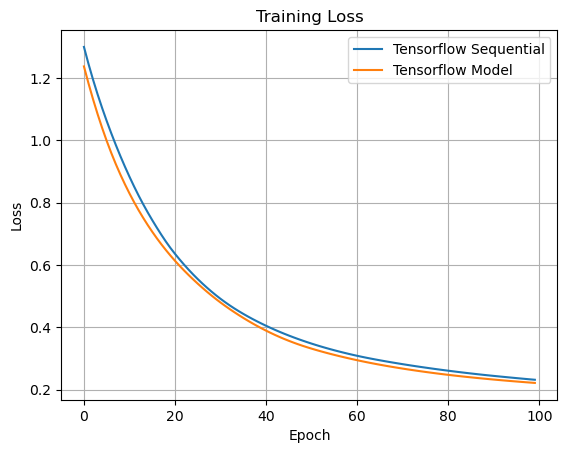

In [28]:
plt.plot(losses_tf_seq, label='Tensorflow Sequential')
plt.plot(losses_tf_mod, label='Tensorflow Model')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

## 3.4 Decision boundary

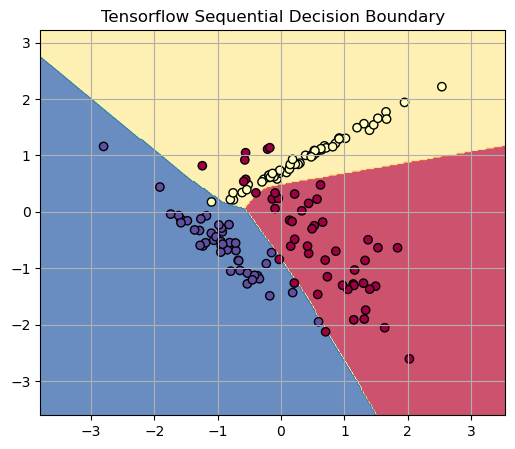

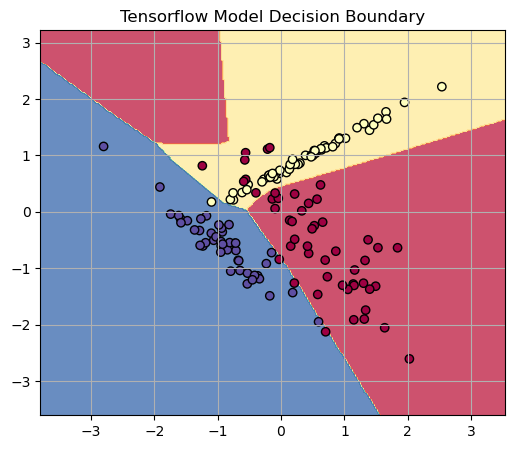

In [32]:
plot_decision_boundary(tf_model_seq, X_test, y_test, "Tensorflow Sequential Decision Boundary", is_torch=False)
plot_decision_boundary(tf_model_mod, X_test, y_test, "Tensorflow Model Decision Boundary", is_torch=False)